# Suicide Rate Prediction Regression Model

The purpose of this notebook is to create a regression model to predict the suicide rate of a city in a certain year. 

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located and the suicide rate from the previous year.

---

Import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# DataPrep
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import pickle
import joblib

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import geoplot
# import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../"

In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [ ]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("/")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [ ]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

Filling NaN values with zero and getting state code from MUNCOD column

In [ ]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
df = df[(np.abs(stats.zscore(df["RATE"])) < 3)] 
df.head()

In [ ]:
df.to_csv("df_regression.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [ ]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

In [ ]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
train_df = train_df[(np.abs(stats.zscore(train_df["RATE"])) < 3)] 

train_df.head()

In [ ]:
train_df.to_csv("train_data_regression.csv")

Getting testing data (2018)

In [ ]:
percentage_valid_values = 0.8
col_year_suicide = "RATE_18"
col_year_prev = "RATE_17"
test_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
test_df = test_df.rename(columns={col_year_suicide: "RATE"})
test_df = test_df.rename(columns={col_year_prev: "PREVIOUS"})
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df = disease_df.rename(columns={col_year_disease: disease})

    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)  
test_df = test_df.dropna(thresh=N)

test_df.head()

In [ ]:
test_df.to_csv("test_data_regression.csv")

# Model

In [3]:
df = pd.read_csv("df_regression.csv",index_col=0)
train_df = pd.read_csv("train_data_regression.csv", index_col=0)
test_df = pd.read_csv("test_data_regression.csv", index_col=0)

Defining X and y

In [4]:
X = df.drop(columns=["RATE"])
y = df["RATE"]

X.shape

(9640, 341)

Defining some functions

In [5]:
def calcUpMetrics(y_pred,y_test,X_test):
    up_df = pd.DataFrame({"Pred": y_pred, "Real": y_test, "Previous": X_test["PREVIOUS"]})
    up_df["UP"] = up_df["Previous"] < up_df["Real"]
    up_df["UP_PRED"] = up_df["Previous"] < up_df["Pred"]
    up_df["UP"] = up_df["UP"].astype(int)
    up_df["UP_PRED"] = up_df["UP_PRED"].astype(int)
    return metrics.recall_score(up_df["UP"], up_df["UP_PRED"])
#     return up_df

In [6]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature")
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df

In [7]:
def cor_feature_selector(X,y,corr_min_value):
    cor_list = []
    for i in list(X.columns):
        cor = np.corrcoef(X[i], y)[0,1]
        cor_list.append([i, cor])
    cor_feature = [x[0] for x in cor_list if abs(x[1]) > corr_min_value]
    print(len(cor_feature), "selected features (correlation)")
    return cor_feature

In [8]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,y_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
    rmse_baseline_train = np.sqrt(metrics.mean_squared_error(X_train["PREVIOUS"],y_train))
    rmse_baseline_test = np.sqrt(metrics.mean_squared_error(X_test["PREVIOUS"],y_test))
    up_down_train = calcUpMetrics(y_pred_train,y_train,X_train)
    up_down_test = calcUpMetrics(y_pred,y_test,X_test)
                                 
    print("RMSE Train:", rmse_train)
    print("RMSE Test:", rmse_test)
    print("RMSE Baseline Train:", rmse_baseline_train)
    print("RMSE Baseline Test:", rmse_baseline_test)
    print("Up/Down Recall Train:", up_down_train)
    print("Up/Down Recall Test:", up_down_test)
    if scores is not None:
        scores = scores.append({'rmse_train':rmse_train, 'rmse_test':rmse_test, "rmse_baseline_train": rmse_baseline_train, "rmse_baseline_test": rmse_baseline_test, "up_down_train": up_down_train, "up_down_test": up_down_test},ignore_index=True)
        return scores

In [9]:
num_feat = 50
corr_min_value = 0.05
all_models_scores = {}

## Random Forest

### No Scaling

In [10]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                                  max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY Random Forest ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["Random Forest"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 1.5453095976914502
RMSE Test: 3.646251590029542
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.9588286459843433
Up/Down Recall Test: 0.7821428571428571
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 1.677651165800043
RMSE Test: 3.5317366757855844
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.9491923641703377
Up/Down Recall Test: 0.8076923076923077
# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Opt

In [11]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)

with open('selected_cor_features', 'wb') as fp:
    pickle.dump(selected_cor_features, fp)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                              max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/random_forest_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

126 selected features (correlation)


### SHAP

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5)

print("# Feature Selection: correlation")
selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
X_train = X_train[selected_cor_features]
X_test = X_test[selected_cor_features]

print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

print("# Fitting the model")
regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                              max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train,y_train)

print("# Making predictions")
y_pred = regressor.predict(X_test) 
y_pred_train = regressor.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# Get Feature Importance")
importance = regressor.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))

# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 1.5318851838038414
RMSE Test: 3.6474205072623413
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.9559292548564802
Up/Down Recall Test: 0.7976190476190477
# Get Feature Importance
                                               Feature  Importance
114                                           PREVIOUS    0.133087
122                                                 RS    0.029439
29       TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS    0.021141
96                                 DOENÇAS_DO_APÊNDICE    0.012840
4    TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT    0.012805
..                                                 ...         ...
121                                                 RJ    0.000239
116                                                 BA    0.0000

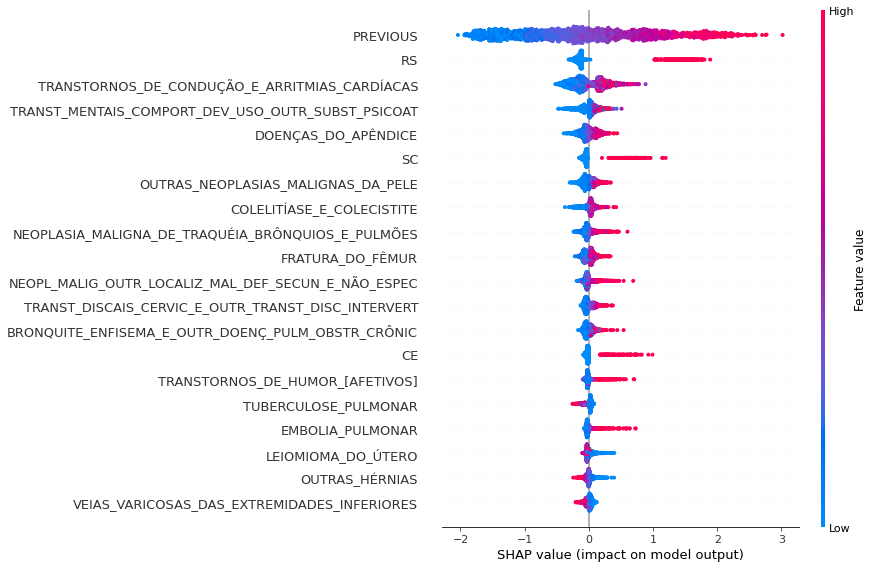

In [15]:
explainer = shap.TreeExplainer(regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### SHAP Individual Analysis

In [16]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["RATE"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RATE"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(data_for_prediction)

3685    1.741006
Name: RATE, dtype: float64


In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

## AdaBoost

In [26]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        learning_rate = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (30,200), #n_estimators
        (0.01, 1) #learning_rate
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY AdaBoost ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["AdaBoost"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.6814350082895957
RMSE Test: 3.7853771621517858
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.8521310524789795
Up/Down Recall Test: 0.8238095238095238
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.6928384462698403
RMSE Test: 3.655694655967712
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.8067547723935389
Up/Down Recall Test: 0.8031674208144797
# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.6965292921002733
RMSE Test: 3.7815447030541

The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.6697853193680574
RMSE Test: 3.805269740937545
RMSE Baseline Train: 4.930784973910473
RMSE Baseline Test: 5.003980730784661
Up/Down Recall Train: 0.8488372093023255
Up/Down Recall Test: 0.8433451118963486
# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.6929032623028064
RMSE Test: 3.7135714158512045
RMSE Baseline Train: 4.919021930072528
RMSE Baseline Test: 5.050077028688922
Up/Down Recall Train: 0.8502177068214805
Up/Down Recall Test: 0.8436018957345972
# Get Feature Importance


=============== SUMMARY AdaBoost ===============
# Average Metrics
rmse_train             3.686698
rmse_test              3.748292
rmse_baseline_train    4.945446
rmse_baseline_test     4.944454
up_down_train          0.834304
up_down_test           0.

In [27]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    learning_rate = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (30,200), #n_estimators
    (0.01, 1) #learning_rate
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/adaboost_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## Gradient Boosting

In [28]:
from sklearn.model_selection import KFold
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        learning_rate = params[1]
        max_depth = params[2]
        min_samples_splits = params[3]
        min_samples_leafs = params[4]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
                                          max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (30,200),  #n_estimators
        (0.01, 1), #learning_rate
        (1,32),    #max_depth
        (0.1, 1),  #min_samples_splits 
        (0.1, 0.5) #min_samples_leafs 
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
                                         max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY Gradient Boosting ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["Gradient Boosting"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.5122545115401493
RMSE Test: 3.7017342200014025
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.8147289069295448
Up/Down Recall Test: 0.7619047619047619
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.4597363310280294
RMSE Test: 3.5920347655506832
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.813215859030837
Up/Down Recall Test: 0.7975113122171946
# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Op

In [29]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    learning_rate = params[1]
    max_depth = params[2]
    min_samples_splits = params[3]
    min_samples_leafs = params[4]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
                                      max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (30,200), #n_estimators
    (0.01, 1), #learning_rate
    (1,32), #max_depth
    (0.1, 1), #min_samples_splits 
    (0.1, 0.5) #min_samples_leafs 
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
                                     max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/gradient_boost_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## SVR

### MinMax

In [30]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    mm_x.fit(X_train)
#     yy
    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    mm_y.fit(y_reshape)
    X_train = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        gamma = params[0]
        C = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

        model = SVR(gamma=gamma, C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.001,0.9), #gamma
        (1,10000),   #C
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
    regressor.fit(X_train,y_train.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    y_pred_train_reshaped = mm_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = mm_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = mm_y.inverse_transform(y_train.values)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY SVR MM ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["SVR MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.3925962399751763
RMSE Test: 3.6549475451633713
RMSE Baseline Train: 6.954697977312794
RMSE Baseline Test: 6.959251589526632
Up/Down Recall Train: 1.0
Up/Down Recall Test: 0.9994249568717654


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.4901307696281916
RMSE Test: 3.5390136777657735
RMSE Baseline Train: 6.979449434467671
RMSE Baseline Test: 6.859418406521007
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.1330602241407126
RMSE Test: 3.6774728964896592
RMSE Baseline Train: 6.907498434483828
RMSE Baseline Test: 7.107151128720346
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.3783266073481917
RMSE Test: 3.7005901677599815
RMSE Baseline Train: 6.940562489864613
RMSE Baseline Test: 7.015472030164534
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.4657375977237717
RMSE Test: 3.550850537784041
RMSE Baseline Train: 6.987899579117174
RMSE Baseline Test: 6.824918783222236
Up/Down Recall Train: 1.0
Up/D

In [43]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
# X_train = X_train[selected_cor_features]
X_train = X_train[X_test.columns]

mm_x = MinMaxScaler()
mm_y = MinMaxScaler()
joblib.dump(mm_x, "mm_x.save")
joblib.dump(mm_y, "mm_y.save")

mm_x.fit(X_train)
# yy
y_reshape = y_train.values.reshape(-1, 1)
y_df = y_train.to_frame()
mm_y.fit(y_reshape)
X_train = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
y_train = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    gamma = params[0]
    C = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

    model = SVR(gamma=gamma, C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.001,0.9), #gamma
    (1,10000), #C
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
regressor.fit(X_train,y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/svr_mm_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

### StandardScaler

In [32]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    sc_x = StandardScaler()
    sc_y = StandardScaler()
    sc_x.fit(X_train)
    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    sc_y.fit(y_reshape)
    X_train = pd.DataFrame(sc_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(sc_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train = pd.DataFrame(sc_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        gamma = params[0]
        C = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

        model = SVR(gamma=gamma, C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.001,0.9), #gamma
        (1,10000),   #C
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
    regressor.fit(X_train,y_train.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    y_pred_train_reshaped = sc_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = sc_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = sc_y.inverse_transform(y_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY SVR SC ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["SVR SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 2.876464660456242
RMSE Test: 3.6567669604734334
RMSE Baseline Train: 6.969369934663719
RMSE Baseline Test: 6.987097681071065
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 3.1788295881747817
RMSE Test: 3.5436387306137913
RMSE Baseline Train: 6.99309177579372
RMSE Baseline Test: 6.902018749251121
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 0.39458162092534244
RMSE Test: 3.77616883853504
RMSE Baseline Train: 6.929038684785368
RMSE Baseline Test: 7.115326991624015
Up/Down Recall Train: 1.0
Up/Down Recall Test: 1.0


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
RMSE Train: 2.3432206927012937
RMSE Test: 3.6590044198235123
RMSE Baseline Train: 6.952778384097936
RMSE Baseline Test: 7.020621779974654
Up/Down Recall Train: 1.0
Up/Do

In [39]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
# X_train = X_train[selected_cor_features]
X_train = X_train[X_test.columns]

sc_x = StandardScaler()
sc_y = StandardScaler()
joblib.dump(sc_x, "sc_x.save")
joblib.dump(sc_y, "sc_y.save")

sc_x.fit(X_train)
# yy
y_reshape = y_train.values.reshape(-1, 1)
y_df = y_train.to_frame()
sc_y.fit(y_reshape)
X_train = pd.DataFrame(sc_x.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(sc_x.transform(X_test), index=X_test.index, columns=X_test.columns)
y_train = pd.DataFrame(sc_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    gamma = params[0]
    C = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

    model = SVR(gamma=gamma, C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.001,0.9), #gamma
    (1,10000), #C
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
regressor.fit(X_train,y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/svr_sc_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# All Models

Getting a summary of all model results

In [44]:
df_result = pd.DataFrame({"Model": [], 'rmse_train': [], 'rmse_test':[], "rmse_baseline_train": [],
                          "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})

for model,scores in all_models_scores.items():
    df_result = df_result.append({"Model": model,
                                 "rmse_train": scores["rmse_train"].mean(),
                                 "rmse_test": scores["rmse_test"].mean(),
                                 "rmse_baseline_train": scores["rmse_baseline_train"].mean(),
                                 "rmse_baseline_test": scores["rmse_baseline_test"].mean(),
                                 "up_down_train": scores["up_down_train"].mean(),
                                 "up_down_test": scores["up_down_test"].mean()},ignore_index=True)
df_result

,Model,rmse_train,rmse_test,rmse_baseline_train,rmse_baseline_test,up_down_train,up_down_test
0,Random Forest,1.589445,3.612239,4.945446,4.944454,0.955676,0.801685
1,AdaBoost,3.686698,3.748292,4.945446,4.944454,0.834304,0.825399
2,Gradient Boosting,3.504021,3.675367,4.945446,4.944454,0.806077,0.784797
3,SVR MM,3.371970,3.624575,6.954022,6.953242,1.000000,0.999885
4,SVR SC,2.373122,3.640813,6.969117,6.968305,1.000000,1.000000
